после просмотра презентации настало время практики 🙌

In [1]:
# установка библиотеки
# ! pip3 list
# ! pip3 install sklearn

# Naive Bayes (Наивный Байес)

Давайте сделаем простую классификацию писем на "спам/не спам". Например, на [этих данных](https://www.kaggle.com/uciml/sms-spam-collection-dataset)



In [2]:
# ячейка импортов

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

# from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

In [24]:
# читаем данные

data = pd.read_csv('spam.csv', encoding='latin-1') # обратите внимание на кодировку
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [25]:
# Почистим датафрейм

data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

data = data.rename(columns={"v1": "spam", "v2": "content"})


display(data)

,spam,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


давайте посчитаем распределение спама/не спама

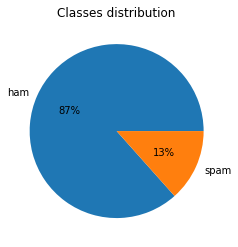

In [39]:
classes =pd.value_counts(data["spam"])

classes.plot(kind = 'pie',  autopct='%0.f%%') 
# про string formatting https://realpython.com/python-string-formatting/

plt.title("Classes distribution")

plt.ylabel('')

plt.show()

**Анализ данных**

Давайте найдем частоты слов в сообщениях (отдельно для подкорпуса спама и не-спама). Для будущего алгоритма, слова будут признаками (features)

Для этого используем Counter из collections.

In [6]:
# заберем все слова по условию, заджойним в строку, разобьем по пробелам, возьмем топ-20
count1 = Counter(" ".join(data[data['spam']=='ham']["content"]).split()).most_common(20) 
df1 = pd.DataFrame.from_dict(count1) # новый дф
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})

# тот же набор операций для второго подкорпуса
count2 = Counter(" ".join(data[data['spam']=='spam']["content"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

display(df1,df2)

,words in non-spam,count
0,to,1530
1,you,1458
2,I,1436
3,the,1019
4,a,969
5,and,738
6,i,736
7,in,734
8,u,645
9,is,638


,words in spam,count_
0,to,604
1,a,358
2,your,187
3,call,185
4,or,185
5,the,178
6,2,169
7,for,169
8,you,164
9,is,143


очень много "шума", давайте избавимся от стоп-слов. Используем [эту функцию](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) из sklearn 

In [7]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')

In [51]:
X = f.fit_transform(data["content"])

display(X.shape)
display(X.toarray())

(5572, 8404)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

метод ```.fit_transform()``` выучивает обучающие данные и возвращает матрицу формата "документ-термин" для всего датасета

Сейчас у нас 8404 признака. Новый признак  j  в ряду i  равен 1 если слово j  появляется в тексте i . В ином случае значение признака = 0

**давайте попробуем предсказать:** окажется ли письмо спамом или не спамом

Следует помнить о двух нежелательных вариантах:

- спам-письмо классифицируется как нормальное (False Negative)
- обычное письмо классифицируется как спам (False positive).
(какой вариант хуже?)

Сначала, представим значения spam/ham как числовые (1,0) 

In [53]:
data.head(4)

,spam,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


Затем разделим данные на обучающую и тестовую выборку [этой функцией](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [57]:
data["spam"]=data["spam"].map({'spam':1,'ham':0}) # в первой колонке переименуем значения 'spam' в 1  и 'ham' в 0

# создадим новые переменные
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['spam'], 
                                                                    test_size=0.2, random_state=50)

print(X_train.shape, X_test.shape)


(4457, 8404) (1115, 8404)


алгоритмов наивного байеса несколько, мы возьмем [Multinomial NB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

[дополнительная информация про Naive Bayes](https://nlp.stanford.edu/IR-book/pdf/13bayes.pdf)

Так как алгоритм быстрый, попробуем несколько вариантов с разным параметром регуляризации α .

Затем для каждого проверим Precision, Recall и Accuracy

In [10]:
list_alpha = np.arange(1/100000, 20, 0.11) # evenly spaced values within a given interval

score_train = np.zeros(len(list_alpha)) # задали пустые списки по длине изначального листа
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0

for alpha in list_alpha: # для каждого значения в списке альф
    bayes = naive_bayes.MultinomialNB(alpha=alpha) # используем модель
    bayes.fit(X_train, y_train) # тренируем модель
    
    score_train[count] = bayes.score(X_train, y_train) # итерируемся по индексу в листе, добавляем значения accuracy
    score_test[count]= bayes.score(X_test, y_test)
    
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    
    count = count + 1 # после одной итерации, делаем новый шаг

посмотрим на 10 лучших моделей

In [11]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763
5,0.55001,0.996250,0.976618,0.936508,0.897338
6,0.66001,0.996518,0.976074,0.932540,0.896947
7,0.77001,0.996518,0.976074,0.924603,0.903101
8,0.88001,0.996250,0.976074,0.924603,0.903101
9,0.99001,0.995982,0.976074,0.920635,0.906250



а теперь давайте оставим модель с наивысшей test precision

In [12]:
best_index = models['Test Precision'].idxmax()

display(best_index)

display(models.iloc[best_index])

143

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

Посмотрим, есть ли модели со 100% Precision

In [13]:
models[models['Test Precision']==1].head(10)



,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
143,15.73001,0.979641,0.969549,0.777778,1.0
144,15.84001,0.979641,0.969549,0.777778,1.0
145,15.95001,0.979641,0.969549,0.777778,1.0
146,16.06001,0.979373,0.969549,0.777778,1.0
147,16.17001,0.979373,0.969549,0.777778,1.0
148,16.28001,0.979105,0.967917,0.765873,1.0
149,16.39001,0.979105,0.967917,0.765873,1.0
150,16.50001,0.978837,0.967917,0.765873,1.0
151,16.61001,0.978570,0.967917,0.765873,1.0
152,16.72001,0.978570,0.967917,0.765873,1.0


Давайте из них выберем те, у которых наибольшее accuracy

In [14]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()

bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])

bayes.fit(X_train, y_train)

models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

давайте построим матрицу ошибок ([как работает матрица ошибок]())

In [15]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))


pd.DataFrame(data = m_confusion_test, columns = ['Predicted ham', 'Predicted spam'],
            index = ['Actual ham', 'Actual spam'])

,Predicted ham,Predicted spam
Actual ham,1587,0
Actual spam,56,196


Мы ошиблись в 56 сообщениях 

# Support Vector Machines (SVM, метод опорных векторов)

https://www.kaggle.com/pablovargas/naive-bayes-svm-spam-filtering

попробуем сделать ту же задачу, с алгоритмом SVM

In [16]:
list_C = np.arange(500, 2000, 100) #100000

score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

посмотрим на 10 первых моделей и их метрики:

In [17]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,1.0,0.979337,0.853175,0.99537
1,600.0,1.0,0.979337,0.853175,0.99537
2,700.0,1.0,0.979337,0.853175,0.99537
3,800.0,1.0,0.979337,0.853175,0.99537
4,900.0,1.0,0.979337,0.853175,0.99537
5,1000.0,1.0,0.979337,0.853175,0.99537
6,1100.0,1.0,0.979337,0.853175,0.99537
7,1200.0,1.0,0.979337,0.853175,0.99537
8,1300.0,1.0,0.979337,0.853175,0.99537
9,1400.0,1.0,0.979337,0.853175,0.99537


выберем модель с лучшим test precision

In [18]:
best_index = models['Test Precision'].idxmax()

display(models.iloc[best_index, :])

C                 500.000000
Train Accuracy      1.000000
Test Accuracy       0.979337
Test Recall         0.853175
Test Precision      0.995370
Name: 0, dtype: float64

In [19]:
# посмотрим на модели с почти 100% Precision

models[models['Test Precision']>0.99].head(5)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,1.0,0.979337,0.853175,0.99537
1,600.0,1.0,0.979337,0.853175,0.99537
2,700.0,1.0,0.979337,0.853175,0.99537
3,800.0,1.0,0.979337,0.853175,0.99537
4,900.0,1.0,0.979337,0.853175,0.99537


In [20]:
best_index = models[models['Test Precision']>0.99]['Test Accuracy'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(X_train, y_train)
models.iloc[best_index, :]

C                 500.000000
Train Accuracy      1.000000
Test Accuracy       0.979337
Test Recall         0.853175
Test Precision      0.995370
Name: 0, dtype: float64

построим матрицу ошибок для SVM

In [21]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1586,1
Actual 1,37,215
